#팀 자바 
###(2조)
###### 김지예/염성현/유한정/이규호



##목적

전력 수요에 영향을 미칠만한 추가적인 변수를 찾는 경우 안정적인 전력 수급에 기여할 수 있음.

현재 국내 전력거래소의 예측 오차율은 평균 1.5% 수준.


#-탐구주제-


###전력수요량(얼마나 전기를 사용하는가)과 여러변수간의 상관관계를 구하고(18, 19, 20년도) 
###올해 특정기간(2~5월)에 코로나가 등장한 후 변수들이 그 전년도에 비해 
###어떤 상관관계의 변화를 보이는지 분석하려 함. 

#변수 목록:
### 1. 전력 수요량(Supply)
### 2. 전력 단가(SNP Max)
### 3. 이슬점Dew Max
### 4. 풍속평균(WS Mean)
### 5. 습도평균(Humid Max)
### 6. 휴일(Weekend)
### 7. 유가(Oil WTI)
### 8. 천연가스(Natural Gas)
### 9. 코로나 확진자 수(Corona)

#-예측-

###-예측 1: 전력수요량과 가장 큰 상관관계를 보이는 것은 유가 일것이라 예측함. 
###-이유: 유가가 오르면 개인 뿐만 아니라 사측에도 영향을 줌. 사람들이 아껴 사용할 것이라 생각함.  
  

###-예측 2: 코로나 확진자수가 늘면 그에 따라 전력수요량도 증가할 것이라 예측함.
###-이유: 사람들이 야외활동을 줄이고 재택근무 등 실내에 머무르는 시간이 증가하여 전력수요도 늘어날 것으로 생각함.  
  

###-예측 3: 휴일(바이너리 0/1로 변환)에 전력수요량이 줄어들 것으로 예측함.
###-이유: 여가활동과 외식활동이 늘어나 그에 따른 전력수요량도 줄어들 것으로 예측함.
  
  
###예측 4: 코로나 발생 이후 기간만 떼어내어 분석하면, 전체 기간을 대상으로 분석했을 때와는 다른 상관관계를 보이는 변수들이 다수 출현할 것으로 예측함.
###-이유: 재택근무나 여가방식의 변화 등 '코로나 이후의 삶'이 전력 소비방식에도 차이를 만들었을 것으로 예측함.  

###1. 2018-2020년 5월까지의 변수 데이터가 필요해서, Dacon 사이트를 이용해 데이터를 수집함.

###2. 코로나 데이터는 캐글에서 수집. 

###3. 유가와 천연가스의 결측치는 전일값으로 채움.

###4. 날짜 형식이 다른 건 형식을 맞춰줌.

###5. 미세먼지 데이터를 구하지 못해서 수업시간에 공부했던 '크롤링'을 사용해서 2년 5개월치 일별 자료를 구하기로 함.

###6. 데이터를 모두 수집/전처리 한 뒤 pandas와 matpoltlib을 이용하여 각 변수간의 상관관계를 분석하고 시각화 시킴(선 그래프, 히트맵)

###7. 예측과 비교해서 크게 예상을 벗어난 혹은 예상을 웃도는 변수가 왜 그런 결과를 가져왔는지 추정해 봄.


In [0]:
from datetime import datetime
import time
import numpy as np

import matplotlib.pyplot as plt
import re
import requests
from bs4 import BeautifulSoup
import pandas as pd
import tqdm
import json
import seaborn as sns
My_Key = 'qJ6t5D6riLOPrFXladC2%2Fn0SNoL3H7LwwPVEa%2B1Qs%2FOQHoc6MQYZOd0XXksDMrnoCQx77QrXAcLR1a7u9tBwBQ%3D%3D'
decoded_Key = requests.utils.unquote(My_Key)

In [0]:
########################################################
##### 네이버 금융 유가 크롤링 함수(현시점까지 추출)#####
########################################################

def get_variable(code):
    
    delay = 0.01
    page = 1
    result = []
    start_time = datetime.now()
    
    # 수집
    while(True):
        url = 'https://finance.naver.com/marketindex/worldDailyQuote.nhn?marketindexCd={}&fdtc=2&page={}'.format(code, page)
        data = pd.read_html(url)[0].dropna()
        if page != 1:
            try:
                if data.iloc[-1, 0] == result[-1].iloc[-1, 0]:
                    break
            except:
                break
        result.append(data)
        page += 1
        time.sleep(delay)
    
    # 가공
    oil_price = pd.concat(result).reset_index(drop=True)
    oil_price.columns = ['날짜', '종가', '전일대비', '등락율']
    oil_price['날짜'] = oil_price['날짜'].apply(lambda x: datetime.strptime(x, '%Y.%m.%d'))
    oil_price = oil_price[['날짜', '종가', ]]
    oil_price.insert(0, '코드', code)
    
    end_time = datetime.now()
    print('[{}] 데이터 수집을 종료합니다. (code: {}, 수집시간: {}초, 데이터수: {:,}개)'.format(end_time.strftime('%Y/%m/%d %H:%M:%S'), code, (end_time-start_time).seconds, len(oil_price)))
    return oil_price

In [0]:
################################
##### 서부텍사스 유가 수집 #####
################################

oil_price_du = get_variable('OIL_CL')
oil_price_du.to_csv('oil_wti.csv')

In [0]:
### 2020년 제주도

from tqdm.notebook import tqdm

api_url = 'http://openapi.airkorea.or.kr/openapi/services/rest/UlfptcaAlarmInqireSvc/getUlfptcaAlarmInfo'

dD_list = []
dN_list = []
iC_list = []
mN_list = []
fine_dust_20_dic = {}

#전체 페이지를 알고 있음
pages = 22
for page in tqdm(range(1, pages+1)):
    params = {
        'ServiceKey' : decoded_Key,
        'pageNo' : page,
        'year' : 2020
    }
    resp = requests.get(api_url, params)
    soup = BeautifulSoup(resp.text, 'lxml')

#받아온 데이터가 item 이후 태그로 구분됨
    dD_tag = soup.select('item datadate')
    for i in range(len(dD_tag)):
      # dD_list.append(str(dD_tag[i]).replace('</datadate>',''))
#><태그 안에 있는 값만 도출, [0]을 해준 것은 리스트 안의 str을 뽑아주기 위함      
      dD_list.append(re.findall('\>(.+?)\<',str(dD_tag[i]))[0])

    dN_tag = soup.select('item districtname')
    for i in range(len(dN_tag)):
      dN_list.append(re.findall('\>(.+?)\<',str(dN_tag[i]))[0])
    
    mN_tag = soup.select('item movename')
    for i in range(len(mN_tag)):
      mN_list.append(re.findall('\>(.+?)\<',str(mN_tag[i]))[0])
    
    iC_tag = soup.select('item itemcode')
    for i in range(len(iC_tag)):
      iC_list.append(re.findall('\>(.+?)\<',str(iC_tag[i]))[0])

#리스트를 딕셔너리 안에 넣어줌
fine_dust_20_dic = {'dataDate':dD_list,
                    'districtName':dN_list,
                    'moveName':mN_list,
                    'itemCode':iC_list
                    }
#딕셔너리를 데이터프레임으로 변환후 csv로 저장                    
fine_dust_20_df = pd.DataFrame(fine_dust_20_dic)
fine_dust_20_df.to_csv('fine_dust_20_df.csv')

In [0]:
fine_dust_20_df[fine_dust_20_df['districtName']=='제주']

,dataDate,districtName,moveName,itemCode
140,2020-02-10,제주,제주권역,PM25
187,2020-01-19,제주,제주권역,PM25


In [0]:
### 2019년 제주도


from tqdm.notebook import tqdm

api_url = 'http://openapi.airkorea.or.kr/openapi/services/rest/UlfptcaAlarmInqireSvc/getUlfptcaAlarmInfo'

dD_list = []
dN_list = []
iC_list = []
mN_list = []
fine_dust_19_dic = {}

pages = 74
for page in tqdm(range(1, pages+1)):
    params = {
        'ServiceKey' : decoded_Key,
        'pageNo' : page,
        'year' : 2019
    }
    resp = requests.get(api_url, params)
    soup = BeautifulSoup(resp.text, 'lxml')

    dD_tag = soup.select('item datadate')
    for i in range(len(dD_tag)):
      dD_list.append(re.findall('\>(.+?)\<',str(dD_tag[i]))[0])

    dN_tag = soup.select('item districtname')
    for i in range(len(dN_tag)):
      dN_list.append(re.findall('\>(.+?)\<',str(dN_tag[i]))[0])
    
    mN_tag = soup.select('item movename')
    for i in range(len(mN_tag)):
      mN_list.append(re.findall('\>(.+?)\<',str(mN_tag[i]))[0])
    
    iC_tag = soup.select('item itemcode')
    for i in range(len(iC_tag)):
      iC_list.append(re.findall('\>(.+?)\<',str(iC_tag[i]))[0])

fine_dust_19_dic = {'dataDate':dD_list,
                    'districtName':dN_list,
                    'moveName':mN_list,
                    'itemCode':iC_list
                    }

fine_dust_19_df = pd.DataFrame(fine_dust_19_dic)

fine_dust_19_df.to_csv('fine_dust_19_df.csv')

In [0]:
fine_dust_19_df[fine_dust_19_df['districtName']=='제주']

,dataDate,districtName,moveName,itemCode
9,2019-12-11,제주,제주권역,PM25
93,2019-11-18,제주,제주권역,PM10
136,2019-11-01,제주,제주권역,PM10
162,2019-10-29,제주,제주권역,PM10
252,2019-05-02,제주,제주권역,PM10
259,2019-05-01,제주,제주권역,PM25
291,2019-04-05,제주,제주권역,PM25
408,2019-03-06,제주,제주권역,PM25
468,2019-03-04,제주,제주권역,PM10
491,2019-03-04,제주,제주권역,PM25


In [0]:
### 2018년 제주도


from tqdm.notebook import tqdm

fine_dust_18_dic = {'dataDate':dD_list,
                    'districtName':dN_list,
                    'moveName':mN_list,
                    'itemCode':iC_list
                    }

fine_dust_18_df = pd.DataFrame(fine_dust_18_dic)

api_url = 'http://openapi.airkorea.or.kr/openapi/services/rest/UlfptcaAlarmInqireSvc/getUlfptcaAlarmInfo'

dD_list = []
dN_list = []
iC_list = []
mN_list = []
fine_dust_18_dic = {}

pages = 56
for page in tqdm(range(1, pages+1)):
    params = {
        'ServiceKey' : decoded_Key,
        'pageNo' : page,
        'year' : 2018
    }
    resp = requests.get(api_url, params)
    soup = BeautifulSoup(resp.text, 'lxml')

    dD_tag = soup.select('item datadate')
    for i in range(len(dD_tag)):
      dD_list.append(re.findall('\>(.+?)\<',str(dD_tag[i]))[0])

    dN_tag = soup.select('item districtname')
    for i in range(len(dN_tag)):
      dN_list.append(re.findall('\>(.+?)\<',str(dN_tag[i]))[0])
    
    mN_tag = soup.select('item movename')
    for i in range(len(mN_tag)):
      mN_list.append(re.findall('\>(.+?)\<',str(mN_tag[i]))[0])
    
    iC_tag = soup.select('item itemcode')
    for i in range(len(iC_tag)):
      iC_list.append(re.findall('\>(.+?)\<',str(iC_tag[i]))[0])

fine_dust_18_df.to_csv('fine_dust_18_df.csv')

In [0]:
fine_dust_18_df[fine_dust_18_df['districtName']=='제주']

,dataDate,districtName,moveName,itemCode
9,2019-12-11,제주,제주권역,PM25
93,2019-11-18,제주,제주권역,PM10
136,2019-11-01,제주,제주권역,PM10
162,2019-10-29,제주,제주권역,PM10
252,2019-05-02,제주,제주권역,PM10
259,2019-05-01,제주,제주권역,PM25
291,2019-04-05,제주,제주권역,PM25
408,2019-03-06,제주,제주권역,PM25
468,2019-03-04,제주,제주권역,PM10
491,2019-03-04,제주,제주권역,PM25


In [0]:
#미세먼지 데이터 뽑는 함수

def finedust(yearmonth):
      url = 'https://www.airkorea.or.kr/web/pmRelaySub'
      query = {
          'strDateDiv' : '2',
          'searchDate' : '2020-06-09',
          #지역 번호
          'district' : '064',
          #미세먼지
          #item코드도 input으로 받아서 만들 수 있긴 함.
          'itemCode' : '10007',
          #연도 월
          'searchDate_f' : yearmonth 
      }
      resp = requests.get(url, query)
      soup = BeautifulSoup(resp.content, 'lxml')
      a_tag = soup.select('tbody tr td')
      
      #데이터에 공백이 많아 지워주기 위해서 str로 변환 그리고 replace로 정리
      #.text로 하면 원하지 않는 데이터까지 불러와서 정리해준 후 필요한 데이터만 re.findall로 찾아줌
      s_tag =str(a_tag)
      ss_tag=s_tag.replace(' ','').replace('\t','').replace('\n','').replace('\r','')
      finedust = re.findall('\"\>(.+?)\<\/', ss_tag)

      #월마다 날짜가 달라서 다르게 처리해주기 위해서 days변수를 만듦
      if str(yearmonth)[-2:] in ['01','03','05','07','08','10','12']:
        days=31
      elif str(yearmonth)[-2:] in ['02']:
        days=28
      else:
        days=30
        
      #하나의 큰 리스트 안에 각 일별 데이터가 리스트로 차곡차곡 쌓이길 원함
      #그래서 리스트 공간을 먼저 만들어줌(내포)
      a=[]
      [a.insert(0,[]) for i in range(days+2)]
      #자료를 그대로 넣어주면 추후에 숫자값만 뽑아서 sum을 내기 어려워
      #숫자일 경우 int로 변환해서 리스트 안에 넣어주는 코딩을 짬
      for i in range(len(finedust)):
        for j in range(days+2):
          if i%(days+2) ==j:
             if finedust[i][-1] in ['1','2','3','4','5','6','7','8','9','0']:
               a[j].append(int(finedust[i]))
             else:
               a[j].append(finedust[i])
          else:
             continue
      b=pd.DataFrame(a)
        
      c = 0
      C = []
          
     # Jeju = pd.concat([b.iloc[:,0:1], b.iloc[:,5:8]], ignore_index = True, axis=1)
     # 얘는 모든 제주도 데이터에 7개 권역 자료가 있는 줄 알고 제주시만 뽑아보려 했는데
     # 월마다 권역 개수가 다름 5개 인데도 있고 6개 인데도 있고 그래서 그냥 전체로 평균내기로함
      for k in range(2, len(b)):
        c=0
        for i in range(len(b.iloc[k])):
    #타입이 int면 넣어줭
          if type(b.iloc[k][i])==int:
            c += b.iloc[k][i]
        C.append(c)
      #컬럼 네임을 미리 정의해줌
      #제주 자료라 편하게 제주로 했지만 이것도 받아서 바꿀 수 있음
      cocol='제주'+str(yearmonth)
      CC = pd.DataFrame(C, columns = [cocol], index = [i+1 for i in range(len(b)-2)])
      
      return CC/len(b.iloc[0])
        

In [0]:
#연도마다 정렬을 해주자.
listM = [201801, 201802, 201803, 201804, 201805, 201806, 201807, 201808, 201809, 201810, 201811, 201812]
for i in listM:
  if i == 201801:
    Jeju2018= finedust(listM[0])
  else:
    Jeju2018 = pd.concat([Jeju2018, finedust(i)], axis=1)
Jeju2018

,제주201801,제주201802,제주201803,제주201804,제주201805,제주201806,제주201807,제주201808,제주201809,제주201810,제주201811,제주201812
1,54.8,38.6,51.2,83.6,33.0,32.8,20.2,29.2,11.8,27.6,13.666667,70.833333
2,56.8,24.8,36.0,41.2,30.8,36.8,20.6,32.0,13.4,21.6,15.666667,43.833333
3,49.0,29.0,32.0,37.6,48.8,34.2,21.4,26.0,15.6,19.4,16.833333,16.666667
4,30.0,13.6,22.8,34.2,38.4,30.8,28.6,26.8,18.4,22.2,16.666667,38.000000
5,27.0,20.4,15.0,22.2,41.2,21.0,26.8,22.0,24.2,12.2,31.333333,31.000000
6,25.6,15.2,27.0,84.6,26.2,29.8,18.0,23.0,30.6,10.2,29.666667,26.666667
7,22.2,18.2,31.0,58.2,22.2,33.4,26.8,25.8,27.0,30.2,23.333333,20.000000
8,19.6,36.4,28.2,58.4,33.0,32.0,19.6,26.0,20.0,18.4,13.000000,12.666667
9,42.6,35.4,52.0,78.2,38.0,41.0,19.6,25.2,20.6,23.6,19.500000,11.833333
10,25.4,54.4,31.4,46.4,43.0,28.4,27.4,23.6,23.2,25.8,25.833333,12.833333


In [0]:
Jeju2018.to_csv('Jeju2018.csv')

In [0]:
listM = [201901, 201902, 201903, 201904, 201905, 201906, 201907, 201908, 201909, 201910, 201911, 201912]
for i in listM:
  if i == 201901:
    Jeju2019= finedust(listM[0])
  else:
    Jeju2019 = pd.concat([Jeju2019, finedust(i)], axis=1)
Jeju2019

,제주201901,제주201902,제주201903,제주201904,제주201905,제주201906,제주201907,제주201908,제주201909,제주201910,제주201911,제주201912
1,19.333333,37.666667,119.500000,33.166667,58.500000,31.000000,21.000000,14.166667,24.166667,16.000000,171.000000,18.285714
2,29.333333,54.500000,75.833333,46.166667,111.333333,31.000000,24.666667,20.333333,21.666667,0.000000,91.500000,22.000000
3,18.000000,39.166667,37.000000,28.833333,62.333333,34.500000,36.833333,30.500000,18.000000,8.666667,63.500000,24.142857
4,24.000000,99.333333,108.500000,27.666667,59.166667,36.333333,39.500000,30.666667,16.666667,55.833333,34.833333,35.428571
5,47.333333,81.666667,122.166667,68.500000,48.833333,26.000000,43.333333,34.500000,18.500000,49.333333,34.666667,30.285714
6,21.666667,41.500000,50.000000,108.833333,50.666667,24.333333,44.833333,38.166667,0.000000,29.666667,35.500000,18.571429
7,27.166667,37.000000,56.166667,52.833333,40.166667,32.166667,38.333333,29.166667,0.000000,23.833333,40.166667,28.142857
8,42.833333,17.333333,35.500000,42.000000,33.166667,32.166667,26.833333,25.000000,0.000000,29.166667,29.666667,30.714286
9,21.500000,23.333333,27.166667,46.166667,27.000000,30.500000,27.333333,25.666667,14.166667,21.833333,29.166667,33.571429
10,17.333333,23.666667,18.000000,17.000000,36.833333,28.833333,18.000000,31.833333,37.166667,23.666667,37.333333,34.142857


In [0]:
Jeju2019.to_csv('Jeju2019.csv')

In [0]:
listM = [202001, 202002, 202003, 202004, 202005]
for i in listM:
  if i == 202001:
    Jeju2020= finedust(listM[0])
  else:
    Jeju2020 = pd.concat([Jeju2020, finedust(i)], axis=1)
Jeju2020

,제주202001,제주202002,제주202003,제주202004,제주202005
1,15.625,21.444444,0.0,NaN,NaN
2,34.500,20.555556,0.0,NaN,NaN
3,44.250,22.777778,0.0,NaN,NaN
4,48.250,20.111111,0.0,NaN,NaN
5,43.000,23.666667,0.0,NaN,NaN
6,26.750,23.333333,0.0,NaN,NaN
7,28.750,25.000000,0.0,NaN,NaN
8,34.000,31.555556,0.0,NaN,NaN
9,36.875,30.555556,0.0,NaN,NaN
10,25.625,33.666667,0.0,NaN,NaN


In [0]:
Jeju2020.to_csv('Jeju2020.csv')

In [0]:
#데이터 불러옴(드라이브에 데이터 파일들을 넣어줌)
corona = pd.read_csv('/content/drive/My Drive/multi_data/corona.csv')
data = pd.read_csv('/content/drive/My Drive/multi_data/eda_homework.csv')
data = data.iloc[:,1:]
data_2020 = pd.read_csv('/content/drive/My Drive/multi_data/eda_homework_2020.csv')

In [0]:
#코로나 데이터 정리해서 합쳐줌
corona['date'] = corona['date'].apply(lambda x :re.findall("\d+", x ))
corona['date'] =  corona['date'].apply(lambda x : x[2]+'-'+x[0]+'-'+x[1])

corona_merge = pd.merge(data_2020, corona, how='left')

In [0]:
corona['corona']

0          1
1          1
2          2
3          2
4          3
       ...  
133    11629
134    11668
135    11719
136    11776
137    11814
Name: corona, Length: 138, dtype: int64

In [0]:
#코로나 데이터 내의 데이터가 누적데이터라 차분을해서 일별데이터로 바꿔줌
#왜냐면 전력 데이터는 매일 매일의 수치를 뽑는건데
#코로나 누적 확진자 데이터로 비교를 하면
#어느날 전력이 2, 코로나 확진자(누적)이 10이었다가
#다음날 전력이 2, 코로나 확진자(누적)이 20이 되면
#코로나 확진자(누적)의 변화량이 뻠삥이 되는 거
#그래서 매일매일 갱신되는 데이터는 마찬가지로 매일매일 갱신되는 데이터랑 비교해주는 게 맞음
#안그러면 수치가 이상하게 높거나 낮게 나옴.
corona_diff=[]
for i in range(len(corona)-1):
  if i == range(len(corona)):
    break
  elif i==0:
    corona_diff.append(corona['corona'][0])
  else:
    corona_diff.append(corona['corona'][i+1]-corona['corona'][i])

In [0]:
corona_diff_f=pd.DataFrame(corona_diff,columns=['corona_df'])

In [0]:
#원 데이터와 합쳐줌
corona_merge_f = pd.concat([data_2020, corona_diff_f],axis=1)

In [0]:
corona_merge_f.head()

,date,supply,smp_max,dew_max,ws_min,humid_max,weekend,oil_wti,natural_gas,corona_df
0,2020-01-22,83.08,207.03,12.9,0.4,98.0,0.0,56.74,1.905,1
1,2020-01-23,75.65,152.37,12.9,0.6,99.0,0.0,55.59,1.926,1
2,2020-01-24,71.58,152.68,7.9,1.1,78.0,0.0,54.19,1.893,0
3,2020-01-25,70.02,155.46,10.2,1.4,84.0,1.0,NaN,NaN,1
4,2020-01-26,72.42,92.32,9.3,1.7,87.0,1.0,NaN,NaN,1


In [0]:
corona_merge_f.to_csv("corona_merge_f.csv", index=False)

In [0]:
print(data.shape)
print(corona_merge_f.shape)
data.info()
corona_merge_f.info()

(838, 8)
(137, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 838 entries, 0 to 837
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   supply       838 non-null    float64
 1   smp_max      838 non-null    float64
 2   dew_max      838 non-null    float64
 3   ws_min       838 non-null    float64
 4   humid_max    838 non-null    int64  
 5   weekend      838 non-null    int64  
 6   oil_wti      578 non-null    float64
 7   natural_gas  586 non-null    float64
dtypes: float64(6), int64(2)
memory usage: 52.5 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137 entries, 0 to 136
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         118 non-null    object 
 1   supply       118 non-null    float64
 2   smp_max      118 non-null    float64
 3   dew_max      118 non-null    float64
 4   ws_min       118 non-null    float64
 5   hu

In [0]:
####################################################
##### 2018-2020 코로나 제외 데이터 기초 통계량 #####
####################################################

data_kurt = pd.DataFrame(data.kurt()).T
data_kurt.index = ['kurt']
data_skew = pd.DataFrame(data.skew()).T
data_skew.index = ['skew']

data_basic_stat = data.describe(include='all')
data_basic_stat = pd.concat([data_basic_stat, data_kurt, data_skew])

data_basic_stat

,supply,smp_max,dew_max,ws_min,humid_max,weekend,oil_wti,natural_gas
count,838.000000,838.000000,838.000000,838.000000,838.000000,838.000000,578.000000,586.000000
mean,74.225501,178.784558,13.102506,1.137470,82.249403,0.323389,56.890917,2.599841
std,8.783878,30.421106,8.256100,0.974283,12.603544,0.468049,13.028222,0.569025
min,55.950000,86.450000,-5.900000,0.000000,28.000000,0.000000,-37.630000,1.537000
25%,66.530000,161.232500,6.800000,0.500000,72.000000,0.000000,53.442500,2.243250
50%,73.235000,178.910000,13.050000,0.900000,84.000000,0.000000,58.450000,2.639000
75%,81.015000,192.495000,19.675000,1.500000,93.000000,1.000000,65.415000,2.855750
max,96.540000,599.280000,27.400000,6.900000,100.000000,1.000000,76.410000,4.837000
kurt,-0.846962,47.531629,-1.049187,3.937182,-0.558340,-1.431168,6.637250,2.099521
skew,0.422370,3.713368,-0.067225,1.762229,-0.481217,0.756474,-2.037478,0.890140


In [0]:
#Describe를 통해 봐야할 것은 보통 평균, 편차, 분위수값
#아래 코로나 데이터 Describe와 비교하는 것도 방법

In [0]:
##########################################
##### 2020 코로나 데이터 기초 통계량 #####
##########################################

corona_merge_f_kurt = pd.DataFrame(corona_merge_f.kurt()).T
corona_merge_f_kurt.index = ['kurt']
corona_merge_f_skew = pd.DataFrame(corona_merge_f.skew()).T
corona_merge_f_skew.index = ['skew']

corona_merge_f_basic_stat = corona_merge_f.describe(include='all')
corona_merge_f_basic_stat = pd.concat([corona_merge_f_basic_stat, corona_merge_f_kurt, corona_merge_f_skew])

corona_merge_f_basic_stat

,date,supply,smp_max,dew_max,ws_min,humid_max,weekend,oil_wti,natural_gas,corona_df
count,118,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000,82.000000,97.000000,137.000000
unique,118,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2020-02-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,74.714915,182.704576,8.627966,1.262712,79.050847,0.322034,33.076585,1.793103,86.233577
std,NaN,7.103114,38.119927,5.361941,1.097767,12.995625,0.469248,16.277169,0.111832,154.342975
min,NaN,61.380000,86.450000,-3.600000,0.000000,48.000000,0.000000,-37.630000,1.537000,0.000000
25%,NaN,70.025000,154.197500,4.525000,0.525000,69.000000,0.000000,22.457500,1.710000,8.000000
50%,NaN,74.705000,196.520000,8.500000,0.900000,78.500000,0.000000,27.950000,1.811000,27.000000
75%,NaN,79.870000,217.650000,12.250000,1.500000,90.000000,1.000000,49.930000,1.870000,89.000000


In [0]:
corona_merge = corona_merge.fillna(method='ffill')
corona_merge.head()

,date,supply,smp_max,dew_max,ws_min,humid_max,weekend,oil_wti,natural_gas,corona
0,2020-01-22,83.08,207.03,12.9,0.4,98,0,56.74,1.905,1
1,2020-01-23,75.65,152.37,12.9,0.6,99,0,55.59,1.926,1
2,2020-01-24,71.58,152.68,7.9,1.1,78,0,54.19,1.893,2
3,2020-01-25,70.02,155.46,10.2,1.4,84,1,54.19,1.893,2
4,2020-01-26,72.42,92.32,9.3,1.7,87,1,54.19,1.893,3


In [0]:
corona_merge.isnull().sum()

date           0
supply         0
smp_max        0
dew_max        0
ws_min         0
humid_max      0
weekend        0
oil_wti        0
natural_gas    0
corona         0
dtype: int64

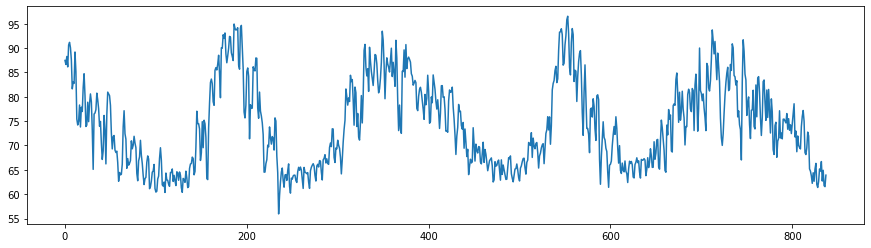

In [0]:
data['supply'].plot(figsize=(15,4))

In [0]:
#전력 수요 데이터에 계절성이 보임
#-> 계절성이 있다는 거는 계절에 따라 데이터가 변동된다는 거고
#-> 그말은 데이터의 변동에 계절이 미치는 영향이 있다는 것이며
#-> 그래서 다른 변수와 직접 비교를 해주기 어렵다는 것
#-> 왜냐면 계절성이라는 요소가 미치는 영향이 크면
#-> 데이터의 추세나 양상이 극화되어 보여지기 때문
#-> 이거를 핸들링(조정)해줘야 하는데 decompose를 통해 할 수 있다함.

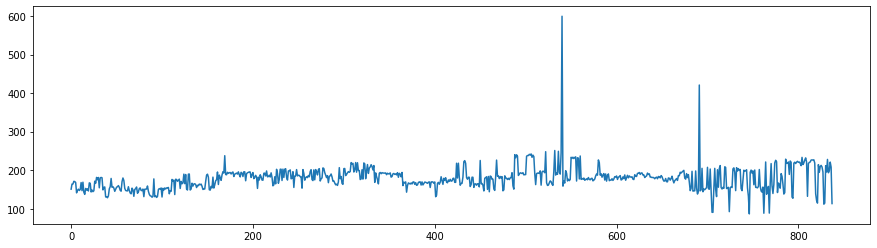

In [0]:
data['smp_max'].plot(figsize=(15,4))

In [0]:
#유가 설명할 때도 얘기했지만 값이 혼자 우뚝 커버리면 다른 이슈에 의해 영향을 받은 경우가 많음
#이거 또한 핸들링 해줘야하는데 방법은 조금 다른 걸로 기억함

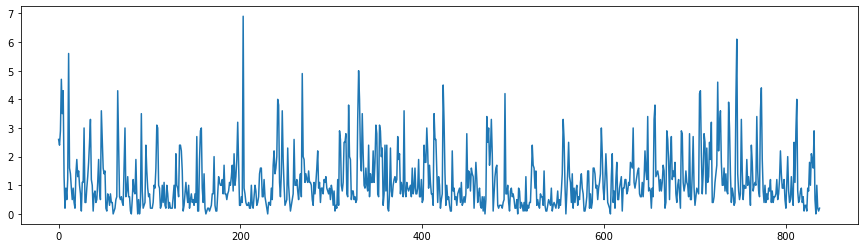

In [0]:
data['ws_min'].plot(figsize=(15,4))

In [0]:
# 아래 그래프와 지금 이 풍속 그래프를 비교하면 풍속은 y축의 값이 0~7로 작음.
# 큰 차이가 없는 그래프인데 시각적으로 크게 보일 수도 있음 
# 그래서 y축 값을 항상 표시해주고 데이터를 잘못 해석하지 않게 주의를 기울여야 함.

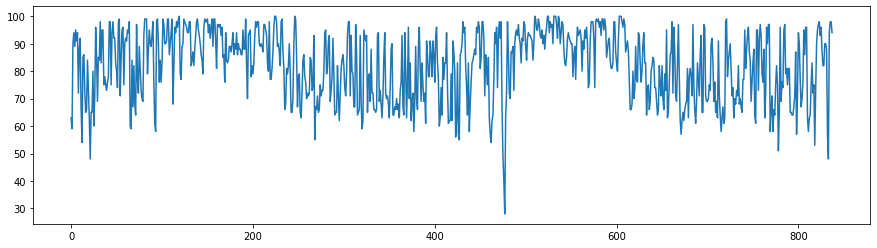

In [0]:
data['humid_max'].plot(figsize=(15,4))

In [0]:
# 설명할 때 노이즈가 크다했는데 자료의 변동이 크다는 것
# 보통 변동폭을 줄여주기 위해서 로그 함수나 기타 함수를 사용하기도 함.
# 근데 자료값을 변경하는 거는 마찬가지로 잘못 해석될 우려가 있기 때문에 주의해야함.

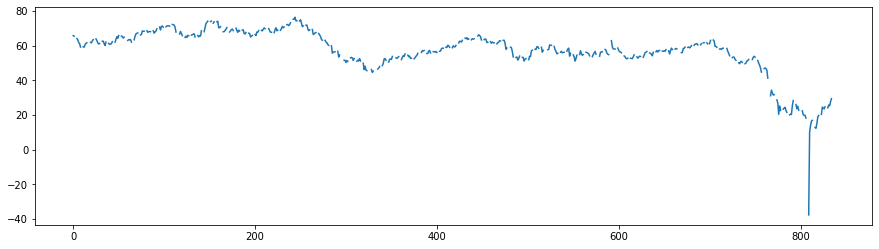

In [0]:
data['oil_wti'].plot(figsize=(15,4))

In [0]:
# 이상치에 대해선 항상 주의를 하고 체크하고 넘어가야 함. 사실 아래에서 상관계수 구하는 것도 이상치를 빼주고 한번 더 해주는 게 좋음
# 그냥 분석이란게 결국은 뭐가 큰 영향을 미쳤는지 알아가는 과정이니까
# 하나 더하고 돌리고 하나 빼고 돌리고 이런거 무한 반복임.

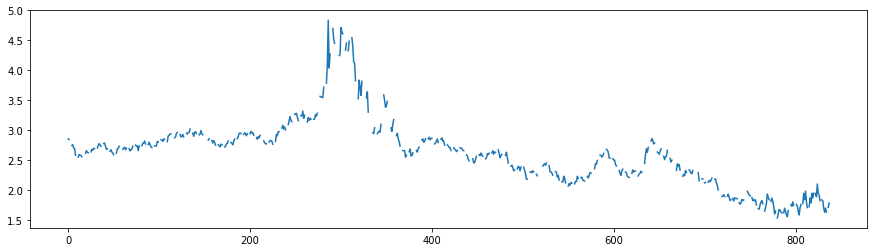

In [0]:
data['natural_gas'].plot(figsize=(15,4))

In [0]:
# 천연가스 그래프인데 이것도 200~400 구간 안에서 급증한 거는 이슈 영향을 받을 가능성이 큼
# 오일이나 천연가스는 알다시피 사건이 많음

In [0]:
smp_max_corr = data[['supply','smp_max']].corr()
print(smp_max_corr)

ws_min_corr = data[['supply','ws_min']].corr()
print(ws_min_corr)

humid_max_corr = data[['supply','humid_max']].corr()
print(humid_max_corr)

oil_wti_corr = data[['supply','oil_wti']].corr()
print(oil_wti_corr)

natural_gas_corr = data[['supply','natural_gas']].corr()
print(natural_gas_corr)

           supply   smp_max
supply   1.000000  0.111247
smp_max  0.111247  1.000000
          supply    ws_min
supply  1.000000  0.185822
ws_min  0.185822  1.000000
             supply  humid_max
supply     1.000000  -0.146512
humid_max -0.146512   1.000000
           supply   oil_wti
supply   1.000000 -0.041703
oil_wti -0.041703  1.000000
               supply  natural_gas
supply       1.000000    -0.090863
natural_gas -0.090863     1.000000


In [0]:
#corr을 시각화하면 한번에 다 볼 수 있긴 해도 이렇게 따로 다 비교해주는게
#놓치지 않고 또 떼어내서 볼 수 있어서 좋긴 함.

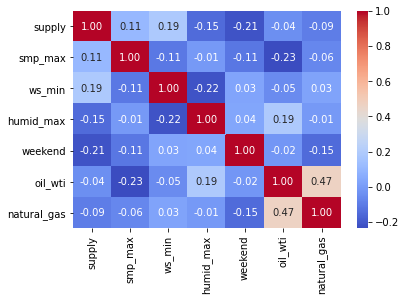

In [0]:
cor_plot = sns.heatmap(data[['supply','smp_max','ws_min','humid_max','weekend','oil_wti','natural_gas']].corr(),cmap='coolwarm', annot=True, fmt='.2f')

In [0]:
# 파이선 히트맵은 먼가 예쁜데 엄청 예쁘지 않음. R은 더 이쁘게 나옴.
# 보통 일일이 살펴보면 좋지만 이상하게 큰 값들을 집중적으로 분석함.

##18~20시즌 전력과 기타 변인간의 상관관계 그래프  
전반적으로 상관계수가 낮은 이유는 계절성이 제거되지 않아 변동이 크고 자료에 노이즈 또한 존재하기 때문  
판단 보류  
물론 할 수 있는 처리를 다해주고 보면 상관계수는 높아짐. 그걸로 모델링하면 예측력도 높아질 거임  
근데 머가 좋은 건지는 매번 헷갈림  

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


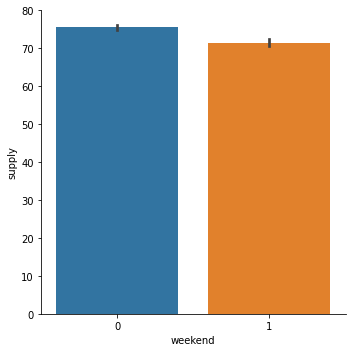

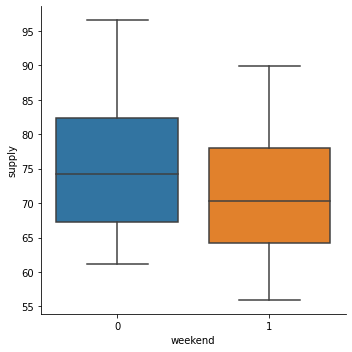

In [0]:
barplot = sns.factorplot(x='weekend', y='supply', data=data, kind='bar')
boxplot = sns.factorplot(x='weekend', y='supply', data=data, kind='box')

In [0]:
# 발표 때 이제 얘기한건 전체 기간떄에는 주말에 비교적 전력 수요가 적은 것으로 보인다.
# 이거를 확정적으로 얘기하려면 통계적 검정인가 검증을 통해 유의값을 구해주는 게 낫지만
# 그런 경향이 있는 것으로 보인다 정도로 방어적으로 얘기하면 되기도 할듯.

In [0]:
corona_merge_f = corona_merge_f.fillna(method='ffill')
corona_merge_f.head()

,date,supply,smp_max,dew_max,ws_min,humid_max,weekend,oil_wti,natural_gas,corona_df
0,2020-01-22,83.08,207.03,12.9,0.4,98.0,0.0,56.74,1.905,1
1,2020-01-23,75.65,152.37,12.9,0.6,99.0,0.0,55.59,1.926,1
2,2020-01-24,71.58,152.68,7.9,1.1,78.0,0.0,54.19,1.893,0
3,2020-01-25,70.02,155.46,10.2,1.4,84.0,1.0,54.19,1.893,1
4,2020-01-26,72.42,92.32,9.3,1.7,87.0,1.0,54.19,1.893,1


In [0]:
corona_merge_f.isnull().sum()

date           0
supply         0
smp_max        0
dew_max        0
ws_min         0
humid_max      0
weekend        0
oil_wti        0
natural_gas    0
corona_df      0
dtype: int64

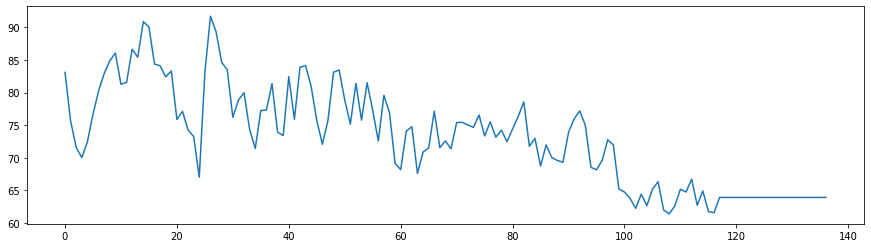

In [0]:
corona_merge_f['supply'].plot(figsize=(15,4))

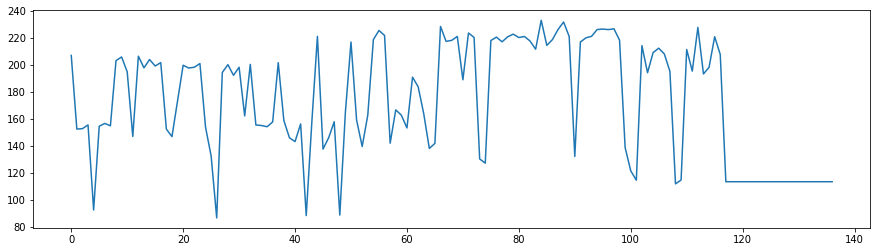

In [0]:
corona_merge_f['smp_max'].plot(figsize=(15,4))

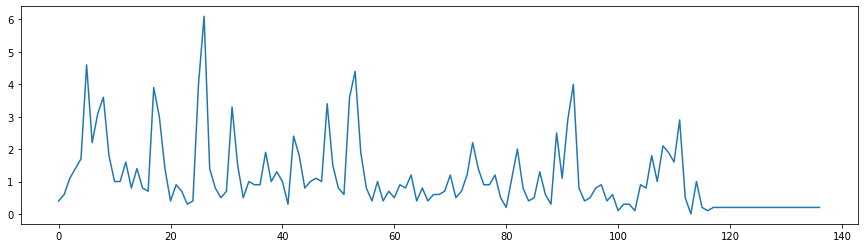

In [0]:
corona_merge_f['ws_min'].plot(figsize=(15,4))

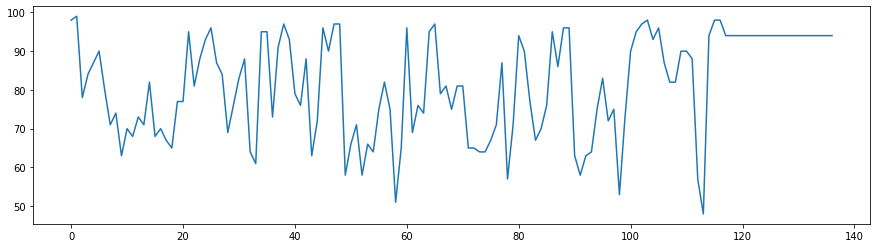

In [0]:
corona_merge_f['humid_max'].plot(figsize=(15,4))

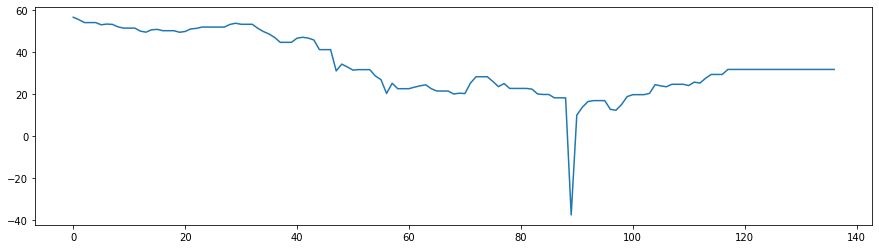

In [0]:
corona_merge_f['oil_wti'].plot(figsize=(15,4))

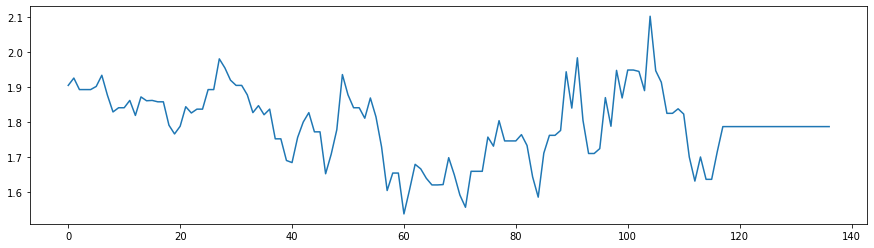

In [0]:
corona_merge_f['natural_gas'].plot(figsize=(15,4))

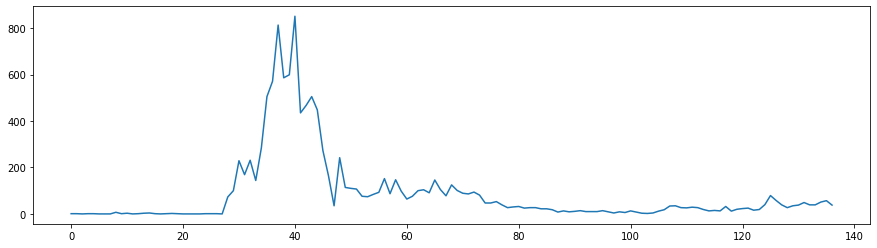

In [0]:
corona_merge_f['corona_df'].plot(figsize=(15,4))

In [0]:
# 누적을 뗀 코로나 일별 확진자 그래프 이것도 40즈음에 급격히 증가한게 신천지 때문일 거다라고 얘기했는데
# 추정가능한 원인을 알고 있으면 분석하고 해석하는데 도움이 많이 됨.
# 왜 급격히 늘어났냐를 설명 못하면 망함.
# 코로나 그래프랑 천연가스 그래프랑 비교하면 엄청 유사하게 나올듯
# 근데 이것도 그냥 우연히 겹친 걸 수도 있음
# 코로나 데이터가 많긴 하지만 올해 발생한거라 천연가스랑 직접적으로 비교하는 것은 어려움.


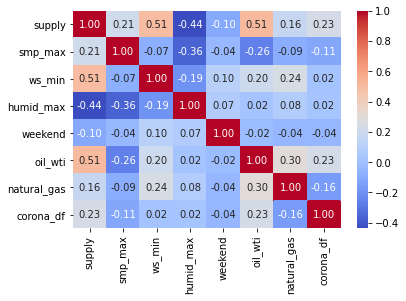

In [0]:
cor_plot = sns.heatmap(corona_merge_f[['supply','smp_max','ws_min','humid_max','weekend','oil_wti','natural_gas','corona_df']].corr(),cmap='coolwarm', annot=True, fmt='.2f')

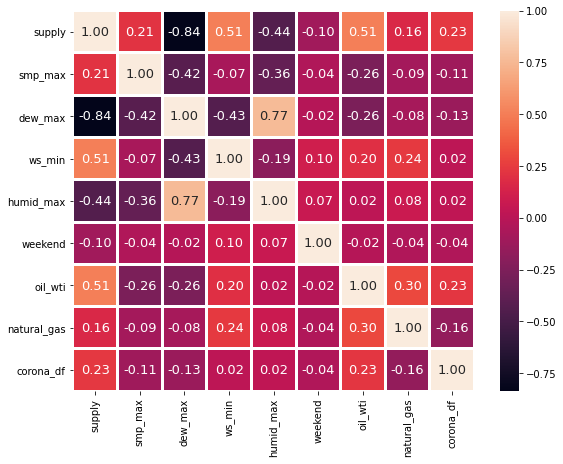

In [0]:
# 이거는 지예가 만든거 dew맥스가 추가됨!
# dew 맥스가 너무 높음, 지예 데이터랑 우리가 계산한 데이터랑 상관계수 값이 조금씩 다른데 불러오는 과정에서 무언가 누락되지 않았을까 싶음
# 우리 데이터든 지예 데이터든
plt.figure(figsize=(9,7))
sns.heatmap(corona_merge_f.corr(), annot=True, annot_kws={'size':13}, lw=2, fmt='.2f')
plt.show()

##코로나 기간 동안을 뽑아낸 상관관계 그래프  
전반적으로 상관계수가 높아진(정확해진, 가설과 비슷하게) 이유는 3개월 분을 떼어네어 계절성이 어느정도 제거되었기 때문이라고 보여짐.  
전력(supply)와 유가(oil_wti)와의 상관관계가 높게 나옴.  
유가가 연초에 급격하게 떨어진 일이 있어서 그 영향이 큰 것 같다.  
그런데 전력수요 데이터가 봄에 감소하는 계절 양상을 보이는데 마침 시기적으로 유가가 급락하게 되어 상관관계가 높아진 경향이 있다고도 보여진다.  
둘 사이에 어떤 인과관계가 작용했다고는 확정하기 어렵다.  

- 이슬점(dew_max)과 전력공급량(supply)은 0.79 음의 상관관계.

  **이슬점(dew_max)**은 공기가 포화되어 수증기가 응결할 때의 온도, 불포화 상태의 공기가 냉각될 때 포화되어 응결이 시작되는 온도이다. 여름철 불쾌지수를 가늠하는 상대 습도보다 중요한 수치인데, 이는 체온이 일정한 만큼 대기 중의 실제 수증기량에 비례하기 때문이다. 또한 수증기가 응축되면서 발생하는 열 때문에 이슬점 이하로는 기온이 내려가기 힘든 만큼, ***이슬점이 높을수록*** 밤에도 기온이 떨어지지 않아 열대야를 유발하게 되는데 이렇게 되면 실내의 열이 밤에도 식지 않아 더위로 인한 불쾌감이 더 심해지며, ***냉방의 필요성이 더 높아지게 된다.***

- 코로나 확진수(corona)와 전력공급량(supply)은 0.67 음의 상관관계. 

- 국제유가(oil_wti)와 전력공급량(supply)은 0.56의 양의 상관관계.

- 풍속(ws_min)과 전력공급량(supply)은 0.41 양의 상관관계.

- 습도(humid_max)와 전력공급량(supply)은 0.31 음의 상관관계.

- 나머지 전력단가(smp_max)와 휴일(weekend) 그리고 천연가스(natural_gas)에 대해서는 뚜렷한 관계성을 보이지 않음.


In [0]:
# 이거 아까 다같이 얘기했지만 변수 설명 이슬점에서 한 것 처럼 자세히 설명해주면 좋음
# 우리는 이 변수(이슬점)를 dew_max라 부르기로 했다. 하고 넘어가면
# 얘네가 도대체 왜 이 변수를 쓴 거지? 이 변수가 의미하는 게 뭐지? 이 변수가 왜 필요한 거지?
# 다른 사람들은 잘 알기가 힘듦
# 그래서 보통 ppt 만들거나 하면 초반에 변수 설명을 줄줄 해줌.

In [0]:
# 상관관계 0.5 이상 아이들

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


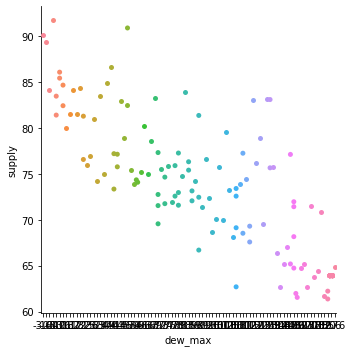

In [0]:
sns.factorplot(x='dew_max', y='supply', data=corona_merge_f, kind='swarm')

In [0]:
# 이런 시도는 좋은 거 같음. 그리고 그래프도 예쁘고
# 사실 상관계수가 높으면 보통 회귀직선을 구했을 때의 기울기도 높아서
# 그래프가 직선에 가깝게 모임
# 그런데 이제 회귀직선을 그었을때 유의값이 낮다는 게 그 직선의 예측력이 높다는 건 아님
# 그냥 직선 적합도가 높다? 해석력이 높다?
# 직선이 데이터들의 분포를 잘 설명해준다 정도임.
# 직선 그은 걸로 데이터하고 다시 비교해줘도 큰 의미 없음.

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


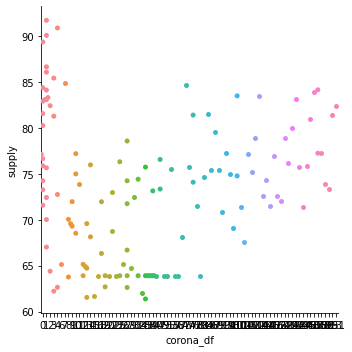

In [0]:
sns.factorplot(x='corona_df', y='supply', data=corona_merge_f, kind='swarm')  # 동떨어진 애

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


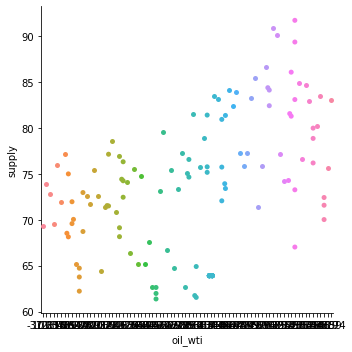

In [0]:
sns.factorplot(x='oil_wti', y='supply', data=corona_merge_f, kind='swarm')  # 왜이렇게 퍼져있지?

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


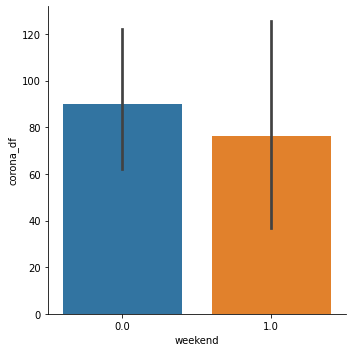

In [0]:
sns.factorplot(x='weekend', y='corona_df', data=corona_merge_f, kind='bar') 

In [0]:
# 여기도 이제 주말에 좀 작게 나옴
# 바그래프로 그렸지만 사실 박스플롯이 좋은게
# 박스플롯이 간단해보여도 설명하는 게 많음
# 사분위나 분포나 평균이나 이상치 모두 나타내기 때문에
# 통계 교수님들도 박스플롯 좋아하심

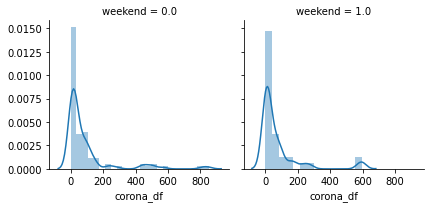

In [0]:
g = sns.FacetGrid(corona_merge_f, col='weekend')
g = g.map(sns.distplot, 'corona_df', kde=True)     # 휴일과 코로나 확진수의 관계 미약

In [0]:
#그래프 상의 큰 차이가 없넹

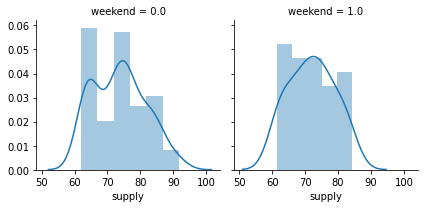

In [0]:
g = sns.FacetGrid(corona_merge_f, col='weekend')
g = g.map(sns.distplot, 'supply', kde=True)  # 오히려 평일에 전력공급이 더 많았다 ==> 집단분위니까?